In [35]:
import numpy as np
from statsmodels.stats import multitest
import collections
import os
import sys
sys.path.append('../../scripts/')
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 16, colors = 'kelly')

In [36]:
def read_tejaas(filename):
    rsidlist = list()
    qscrlist = list()
    qmeanlist = list()
    qvarlist  = list()
    qscalelist = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            qscr = float(linesplit[2])
            qmean = float(linesplit[3])
            qvar = float(linesplit[4])
            pval = float(linesplit[5])
            
            qscale = (qscr - qmean) / qvar
            rsidlist.append(rsid)
            qscrlist.append(qscr)
            qmeanlist.append(qmean)
            qvarlist.append(qvar)
            qscalelist.append(qscale)
            pvallist.append(pval)

    return rsidlist, pvallist, qscrlist, qmeanlist, qvarlist, qscalelist

In [37]:
#sbetalist = ['0.001', '0.01', '0.05', '0.1', '0.2', '0.5', '1.0']
sbetalist = ['0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '0.95', '0.99']

In [22]:
def get_nonzero_pvals(p):
    pvals = np.array(p)
    pmin  = np.min(pvals[np.where(pvals > 0)])
    nonzero_pvals = pvals.copy()
    nonzero_pvals[np.where(pvals == 0)] = pmin
    log10pvals = -np.log10(nonzero_pvals)    
    return nonzero_pvals

In [38]:
pvals = dict()
qstat = dict()
qmean = dict()
qvars = dict()
qscale = dict()

for sbeta in sbetalist:
    pvals[sbeta] = list()
    qstat[sbeta] = list()
    qmean[sbeta] = list()
    qvars[sbeta] = list()
    qscale[sbeta] = list()

    for sim in range(1, 4):
        simdir = "sim{:03d}".format(sim)
        #print(sbeta, simdir)
        paramdir = "10414_450_10_800_30_100_100_0.01_0.5_0.0_0.6_0.6_4.0_0.1_20_0.02"
        srcdir = os.path.join('/scratch/sbanerj/trans-eqtl/simulation/', paramdir, simdir)
        #rrfile = os.path.join(srcdir, 'tejaas/permnull_sb{:s}_knn/raw/peer0/rr.txt'.format(sbeta))
        rrfile = os.path.join(srcdir, 'tejaas/permnull_kf{:s}_knn/raw/peer0/rr.txt'.format(sbeta))

        rr_rsids, rr_pvals, rr_qstats, rr_qmeans, rr_qvars, rr_qscale = read_tejaas(rrfile)
        pvals[sbeta] += rr_pvals
        qstat[sbeta] += rr_qstats
        qmean[sbeta] += rr_qmeans
        qvars[sbeta] += rr_qvars
        qscale[sbeta] += rr_qscale

    qstat[sbeta] = np.array(qstat[sbeta])
    pvals[sbeta] = get_nonzero_pvals(pvals[sbeta])
    qmean[sbeta] = np.array(qmean[sbeta])
    qvars[sbeta] = np.array(qvars[sbeta])
    qscale[sbeta] = np.array(qscale[sbeta])

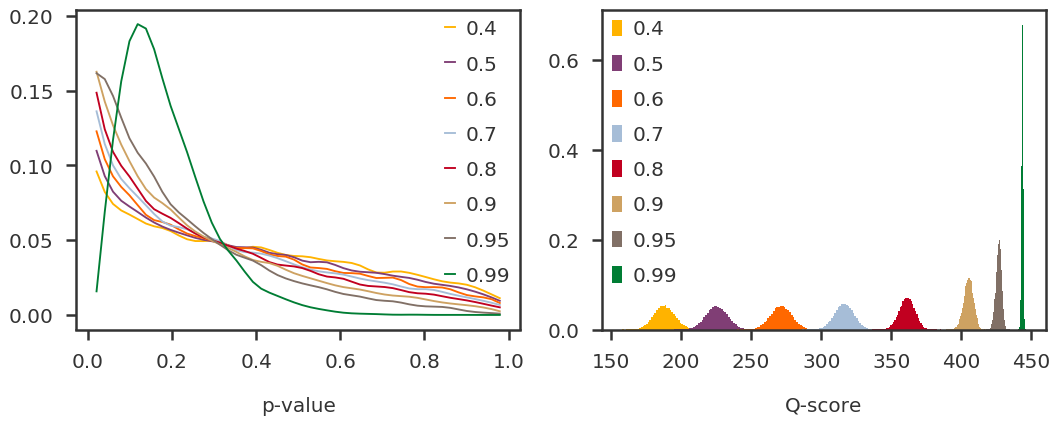

In [39]:
fig = plt.figure(figsize = (12, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)


def plot_distribution_as_outline(data, xmin, xmax, nbin = 50, ninterp = 200):
    bins = np.linspace(xmin, xmax, nbin)
    xbin = [(bins[i] + bins[i+1]) / 2 for i in range(bins.shape[0] - 1)] # centers of the bins
    x = np.linspace(xbin[0], xbin[-1], ninterp)

    yhist, _ = np.histogram(data, bins = bins)
    yfreq = yhist / len(data)
    fy = interp1d(xbin, yfreq, kind = 'cubic')
    y = fy(x)
    return x, y

for sbeta in sbetalist:
    x, y = plot_distribution_as_outline(pvals[sbeta], 0, 1, nbin = 25, ninterp = 50)
    ax1.plot(x, y, label = sbeta)
    ax2.hist(qstat[sbeta], bins = 50, alpha = 1.0, density = True, edgecolor = 'None', label = sbeta)
    
ax1.set_xlabel('p-value')
ax2.set_xlabel('Q-score')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

In [40]:
nplot = len(sbetalist)
ncol  = 4
nrow  = int(nplot / ncol + 0.75)
figw  = ncol * 2.8 + (ncol - 1) * 0.5
figh  = nrow * 2.8 + (nrow - 1) * 0.5

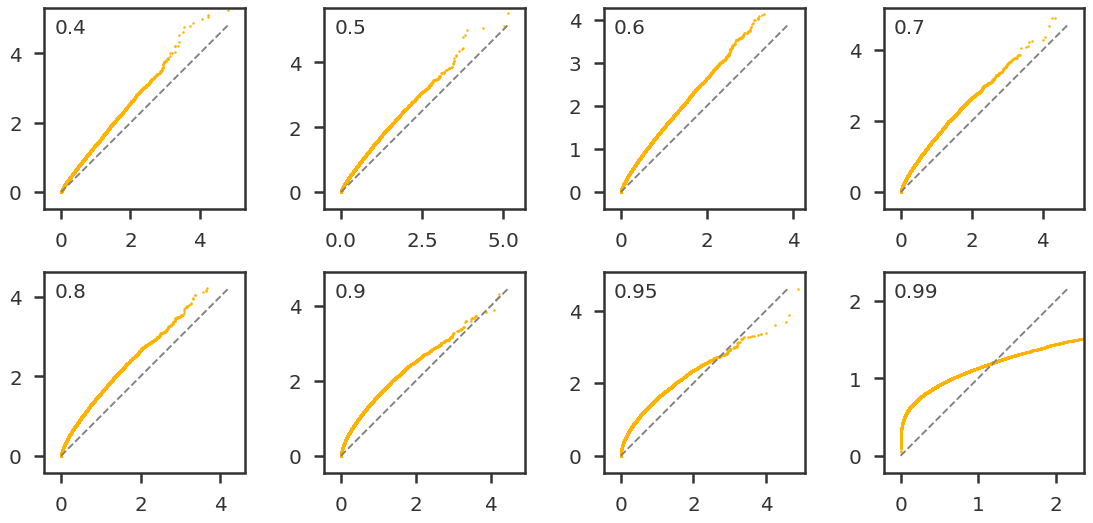

In [41]:
# Q-Q plots

fig = plt.figure(figsize = (figw, figh))

for i, sbeta in enumerate(sbetalist):
    ax = fig.add_subplot(nrow, ncol, i + 1)
    prand = np.random.uniform(0, 1, size = pvals[sbeta].shape[0])
    prand_sort = np.sort(prand)
    pvals_sort = np.sort(pvals[sbeta])
    ax.scatter(-np.log10(prand_sort), -np.log10(pvals_sort), s = 1)
    
    xmax = -np.log10(max(prand_sort[0], pvals_sort[0]))
    xmin = 0
    ax.plot([xmin, xmax], [xmin, xmax], ls = 'dashed', color = 'gray')
    
    eps = xmax / 10
    ax.set_xlim(xmin - eps, xmax + eps)
    ax.set_ylim(xmin - eps, xmax + eps)
    ax.set_aspect('equal')
    ax.text(0.05, 0.95, sbeta, va='top', transform=ax.transAxes)
    

plt.tight_layout()
plt.show()

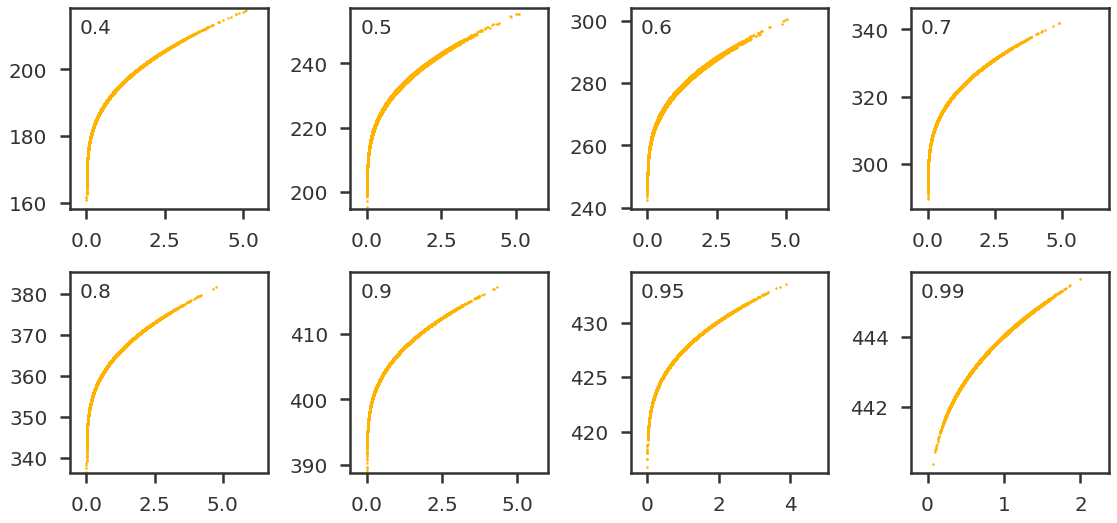

In [16]:
# Compare ranking (p-values vs Q-scores)

fig = plt.figure(figsize = (figw, figh))

for i, sbeta in enumerate(sbetalist):
    ax = fig.add_subplot(nrow, ncol, i + 1)
    x = -np.log10(pvals[sbeta])
    y = qstat[sbeta]
    ax.scatter(x, y, s = 1)
    
    xmax = np.max(x)
    xmin = 0
    ymax = np.max(y)
    ymin = np.min(y)
    #ax.plot([xmin, xmax], ymin, ymax], ls = 'dashed', color = 'gray')
    
    eps = xmax / 10
    ax.set_xlim(xmin - eps, xmax + eps)
    ax.set_ylim(ymin, ymax)
    #ax.set_aspect('equal')
    ax.text(0.05, 0.95, sbeta, va='top', transform=ax.transAxes)
    

plt.tight_layout()
plt.show()

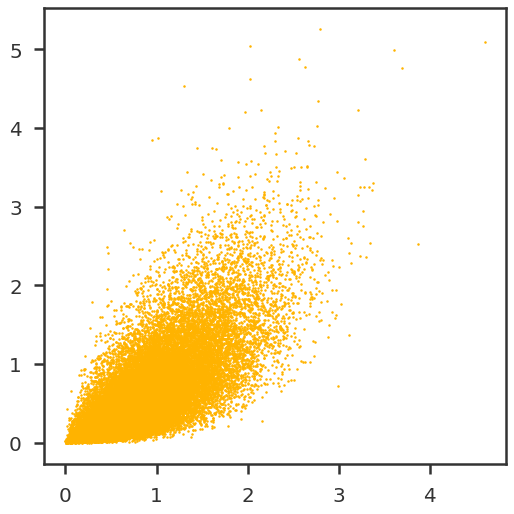

In [20]:
# Compare p-values between two different K_eff

sbeta1 = '0.95'
sbeta2 = '0.4'

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)
x = -np.log10(pvals[sbeta1])
y = -np.log10(pvals[sbeta2])
ax1.scatter(x, y, s = 1)
   

plt.tight_layout()
plt.show()